In [2]:
import pickle
import os
from tools import *
from candidate import Candidate
from numpy import *
from matplotlib import pyplot as plt
import pandas as pd
from deap import *
from deap.tools.emo import sortNondominated
from qiskit import *
from qiskit.quantum_info import state_fidelity
#from main import LRSP_circs

fitnessWeights = (-1.0, -0.5)
creator.create("FitnessMin", base.Fitness, weights=fitnessWeights)
creator.create("Individual", Candidate, fitness=creator.FitnessMin)

def load_files_by_name(basedir):
    loaded = {}
    for name in  next(os.walk(basedir))[2]:
        with open(os.path.join(basedir, name), 'rb') as file:
            loaded[name] = pickle.load(file)
    return loaded
basedir = 'states/5_qubits'
states = load_files_by_name(basedir)

In [3]:
states_with_pop = {}
for name, state in states.items():
    try:
        with open(f'performance_data/5QB/400POP/500-30000GEN-{name}.pop', 'rb') as f:
            states_with_pop[name] = {'state': state, 'pop': pickle.load(f)}
    except:
        pass

In [ ]:
'''print(1-pop[19].fitness.values[0])
qc = pop[19].toQiskitCircuit()
display(qc.draw(output='mpl'))



fit = 1-pop[1].fitness.values[0]

# backend = AerSimulator(method='statevector')
backend = Aer.get_backend('statevector_simulator')
result_state1 = backend.run(qc).result().get_statevector()
print(state_fidelity(state_vector, result_state1))'''

In [4]:
from threading import Thread

def run_init_lrsp_circs(data):
    for name, state in data:
        circs = LRSP_circs(state, initialize_toolbox(state))
        ranks = sortNondominated(circs, len(circs), first_front_only=True)
        front = ranks[0]
        # states_with_pop['lrsp_front'] = front
        f = open('5QB-LRSP-fronts/'+name, 'wb')
        pickle.dump(front, f)
        f.close()
        print(f'finished {name}')

def multithread_chunks(data, chunks, run):
    treds = []
    for i in range(chunks):
        chunk = list(data)[i::chunks]
        print(len(chunk))
        t = Thread(target=run, args=[chunk])
        t.start()
        treds.append(t)

    for t in treds:
        t.join()

In [4]:
def uniqBy(l, f):
    uniq_so_far = []
    uniq_so_far_mapped = []
    for c in l:
        d = f(c)
        if not d in uniq_so_far_mapped:
            uniq_so_far_mapped.append(d)
            uniq_so_far.append(c)
    return uniq_so_far

lrsp_circs = load_files_by_name('5QB-LRSP-fronts')

lrsp_circs_uniq = {name: uniqBy(circs, lambda c: c.circuit) for name, circs in lrsp_circs.items()}



In [12]:
from qiskit.providers.aer import QasmSimulator

backend = AerSimulator(method='density_matrix', noise_model=noise_model)
backend = Aer.get_backend('qasm_simulator')
backend = QasmSimulator(method='density_matrix',noise_model=noise_model)

def totalCNOTs(circ):
    cnots = 0
    for gate in circ:
        if (gate[1]==CNOT): cnots+=1
    return cnots

assert states.keys() == lrsp_circs_uniq.keys()

def noisy_simulation_density_matrix(circ):
    circ.save_density_matrix(label='density_matrix')
    #result = backend.run(circ).result()
    result = execute(circ, backend,
                    coupling_map=connectivity,
                  noise_model=noise_model).result()
    return result.data()['density_matrix']

def run_ga_nondominated_noisy_fids(data):
    for name, obj in data:
        data = []
        state = obj['state']
        pop = sortNondominated(obj['pop'], len(obj['pop']), first_front_only=True)[0]
        pop = uniqBy(pop, lambda c: c.circuit)
        for ind in pop:
            ind_data = {'noisy_fids': []}
            permutation = ind.getPermutationMatrix()
            permutation = np.linalg.inv(permutation)
            cnots = totalCNOTs(ind.circuit)
            for _ in range(100): # find the best circuit from noisy results
                circ = ind.toQiskitCircuit()
                circ.measure_all()
                circ = transpile(circ,fake_machine,optimization_level=0)
                permutation2 = getPermutation(circ)
                perm_circ = Permutation(5, permutation2) # Creating a circuit for qubit mapping
                perm_unitary = Operator(perm_circ) # Matrix for the previous circuit
                density_matrix_noisy = noisy_simulation_density_matrix(circ)
                fid = state_fidelity(perm_unitary @ permutation @ state._data, density_matrix_noisy)
                ind_data['noisy_fids'].append(fid)
            ind_data['cnots'] = cnots
            data.append(ind_data)
            print(f'finished an individual')
            
        f = open('5QB-GA-nondominated-noisy-fids/'+name, 'wb')
        pickle.dump(data, f)
        f.close()
        print(f'finished {name}')  


# multithread_chunks(states_with_pop.items(), 4, run_ga_nondominated_noisy_fids)
run_ga_nondominated_noisy_fids(states_with_pop.items())

finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an individual
finished an

In [195]:
with open('5QB-GA-nondominated-noisy-fids/'+'5QB_state100', 'rb') as f:
    print(pickle.load(f))


[{'noisy_fids': [0.4879411650189644], 'cnots': 5}, {'noisy_fids': [0.4675001118431573], 'cnots': 20}, {'noisy_fids': [0.3027833863417313], 'cnots': 0}, {'noisy_fids': [0.3027833863417313], 'cnots': 0}, {'noisy_fids': [0.46221755212716287], 'cnots': 16}, {'noisy_fids': [0.4842014247242685], 'cnots': 8}, {'noisy_fids': [0.5594685243114866], 'cnots': 11}, {'noisy_fids': [0.5479258103652624], 'cnots': 9}, {'noisy_fids': [0.531214231543304], 'cnots': 4}, {'noisy_fids': [0.470878742558259], 'cnots': 30}, {'noisy_fids': [0.4892234888444488], 'cnots': 13}, {'noisy_fids': [0.4463560107831207], 'cnots': 2}, {'noisy_fids': [0.34352755137734997], 'cnots': 0}, {'noisy_fids': [0.5006035296092037], 'cnots': 23}, {'noisy_fids': [0.4894745788290195], 'cnots': 22}, {'noisy_fids': [0.378748966331091], 'cnots': 24}, {'noisy_fids': [0.46207505219101175], 'cnots': 5}, {'noisy_fids': [0.4691348777400126], 'cnots': 14}, {'noisy_fids': [0.5190655195882794], 'cnots': 26}, {'noisy_fids': [0.13619213721596485], '

In [ ]:
for name, state in states.items():
    circs = lrsp_circs_uniq[name]

    data = []
    for ind in circs:
        ind_data = {'circ': ind, 'noisy_fids': []}
        for _ in range(100): # find the best circuit from noisy results
            permutation = ind.getPermutationMatrix()
            permutation = np.linalg.inv(permutation)
            cnots = totalCNOTs(ind.circuit)
            circ = ind.toQiskitCircuit()
            circ.measure_all()
            circ = transpile(circ,fake_machine,optimization_level=0)
            permutation2 = getPermutation(circ)
            perm_circ = Permutation(5, permutation2) # Creating a circuit for qubit mapping
            perm_unitary = Operator(perm_circ) # Matrix for the previous circuit
            density_matrix_noisy = noisy_simulation_density_matrix(circ)
            fid = state_fidelity(perm_unitary @ permutation @ state._data, density_matrix_noisy)
            ind_data['noisy_fids'].append(fid)
        data.append(ind_data)
    
    #f = open('5QB-LRSP-noisy-fids/'+name, 'wb')
    #pickle.dump(data, f)
    #f.close()
    print(f'finished {name}')


In [5]:
lrsp_noisy_fids = load_files_by_name('5QB-LRSP-noisy-fids')
ga_nondominated_noisy_fids = load_files_by_name('5QB-GA-nondominated-noisy-fids')

[{'noisy_fids': [0.047103175980738404, 0.049752774347398415, 0.04861423808466937, 0.049752774347398415, 0.04860480979686434, 0.04860480979686434, 0.047103175980738404, 0.0493017327656454, 0.04795568501033058, 0.0493017327656454], 'cnots': 5}, {'noisy_fids': [0.048101608666765314, 0.04932146709247243, 0.050383654143156806, 0.04779464382076259, 0.05101961871696411, 0.04838351950763159, 0.0486515753795739, 0.05122684662062364, 0.0464994833444232, 0.0521450312132337], 'cnots': 20}, {'noisy_fids': [0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181], 'cnots': 0}, {'noisy_fids': [0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181, 0.06216668384489181], 'cnots': 0}, {'noisy_fids': [0.04754445970467461, 

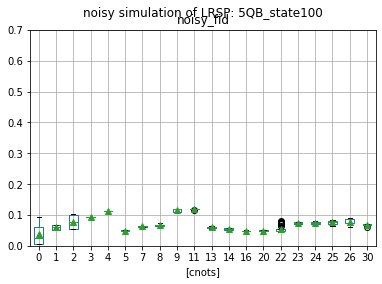

In [7]:
print(ga_nondominated_noisy_fids['5QB_state100'])

for name, results in list(ga_nondominated_noisy_fids.items())[2:3]:
    data = []
    for obj in results:
        for noisy_fid in obj['noisy_fids']:
            data.append({'cnots': obj['cnots'], 'noisy_fid': noisy_fid})

        # display(obj['circ'].toQiskitCircuit().draw(output='mpl', fold=0))
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.ylim(0,0.7)
    df = pd.DataFrame(data)
    df.boxplot(by='cnots', showmeans=1, ax=ax)
    fig.suptitle(f'noisy simulation of LRSP: {name}')

In [ ]:

plt.scatter(*zip(*data))
plt.ylim(0,1)
plt.show()